In [ ]:
# pinn_wave_pytorch.py
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from math import pi

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Parameters in the PDE
c = 1.0            # wave speed
x_min, x_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0

# Training point counts
N_f = 20000    # collocation (interior) points
N_bc = 2000    # boundary points (x=0 and x=1)
N_ic = 2000    # initial condition points (t=0)

In [ ]:
# Neural Network (fully connected)
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

        # xavier init
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: [N, 2] -> (x,t)
        y = x
        for i, layer in enumerate(self.layers[:-1]):
            y = layer(y)
            y = self.activation(y)
        y = self.layers[-1](y)
        return y

In [ ]:
# Network Configuration
layers = [2, 64, 64, 64, 64, 1]  # input: (x,t), output: u
model = PINN(layers).to(device)

# PDE residuals using autograd
def pde_residual(model, x_t):
    """
    Compute residual r = u_tt - c^2 u_xx for (x,t) points.
    x_t: tensor shape [N,2] with requires_grad=True
    """
    u = model(x_t)
    # 1st derivatives
    grads = torch.autograd.grad(u, x_t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:, 0:1]
    u_t = grads[:, 1:2]
    # 2nd derivatives
    u_xx = torch.autograd.grad(u_x, x_t, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_tt = torch.autograd.grad(u_t, x_t, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 1:2]
    residual = u_tt - (c**2) * u_xx
    return residual

In [ ]:
# Initial and boundary condition functions
def u_ic(x):
    # u(x,0) = sin(pi x)
    return torch.sin(pi * x)
def ut_ic(x):
    # u_t(x,0) = 0
    return torch.zeros_like(x)
# Training data sampling
def sample_collocation(N):
    x = torch.rand(N,1)*(x_max-x_min) + x_min
    t = torch.rand(N,1)*(t_max-t_min) + t_min
    xt = torch.cat([x,t], dim=1)
    return xt.to(device)
def sample_initial(N):
    x = torch.rand(N,1)*(x_max-x_min) + x_min
    t = torch.zeros_like(x) + t_min
    xt = torch.cat([x,t], dim=1)
    ux = u_ic(x).to(device)
    utx = ut_ic(x).to(device)
    return xt.to(device), ux.to(device), utx.to(device)
def sample_boundary(N):
    # sample t in (t_min,t_max), x at boundaries 0 and 1
    t = torch.rand(N//2,1)*(t_max-t_min) + t_min
    x0 = torch.zeros_like(t) + x_min
    x1 = torch.zeros_like(t) + x_max
    xt0 = torch.cat([x0, t], dim=1)
    xt1 = torch.cat([x1, t], dim=1)
    return xt0.to(device), xt1.to(device)

In [ ]:
# Prepare Training sets
torch.manual_seed(1234)
xt_f = sample_collocation(N_f)
xt_ic, u0_ic, ut0_ic = sample_initial(N_ic)
xt_b0, xt_b1 = sample_boundary(N_bc)

# set requires_grad for PDE collocation and IC (needed for autograd)
xt_f.requires_grad = True
xt_ic.requires_grad = True
xt_b0.requires_grad = True
xt_b1.requires_grad = True

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Optionally use LBFGS later (uncomment to use)
use_lbfgs = False

# Training loop
mse_loss = nn.MSELoss()

# def closure_lbfgs():
#     optimizer_lbfgs.zero_grad()
#     # PDE residual
#     r = pde_residual(model, xt_f)
#     loss_r = mse_loss(r, torch.zeros_like(r))
#     # IC: u(x,0)
#     u_pred_ic = model(xt_ic)
#     loss_ic_u = mse_loss(u_pred_ic, u0_ic)
#     # IC: u_t(x,0)
#     # compute u_t at xt_ic
#     grads_ic = torch.autograd.grad(u_pred_ic, xt_ic, grad_outputs=torch.ones_like(u_pred_ic), create_graph=True)[0]
#     u_t_pred_ic = grads_ic[:,1:2]
#     loss_ic_ut = mse_loss(u_t_pred_ic, ut0_ic)
#     # BC: u(0,t)=0 and u(1,t)=0
#     u_b0 = model(xt_b0)
#     u_b1 = model(xt_b1)
#     loss_bc = mse_loss(u_b0, torch.zeros_like(u_b0)) + mse_loss(u_b1, torch.zeros_like(u_b1))
#     loss = loss_r + loss_ic_u + loss_ic_ut + loss_bc
#     loss.backward()
#     return loss

print_every = 1000
n_epochs = 10000
if not use_lbfgs:
    for epoch in range(1, n_epochs+1):
        model.train()
        optimizer.zero_grad()
        # PDE residual loss
        r = pde_residual(model, xt_f)
        loss_r = mse_loss(r, torch.zeros_like(r))
        # Initial condition u(x,0)
        u_pred_ic = model(xt_ic)
        loss_ic_u = mse_loss(u_pred_ic, u0_ic)
        # Initial condition u_t(x,0)
        grads_ic = torch.autograd.grad(u_pred_ic, xt_ic, grad_outputs=torch.ones_like(u_pred_ic), create_graph=True)[0]
        u_t_pred_ic = grads_ic[:,1:2]
        loss_ic_ut = mse_loss(u_t_pred_ic, ut0_ic)
        # Boundary conditions
        u_b0 = model(xt_b0)
        u_b1 = model(xt_b1)
        loss_bc = mse_loss(u_b0, torch.zeros_like(u_b0)) + mse_loss(u_b1, torch.zeros_like(u_b1))
        loss = loss_r + loss_ic_u + loss_ic_ut + loss_bc
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0 or epoch==1:
            print(f"Epoch {epoch}/{n_epochs} | Loss: {loss.item():.3e} | PDE {loss_r.item():.3e} | IC_u {loss_ic_u.item():.3e} | IC_ut {loss_ic_ut.item():.3e} | BC {loss_bc.item():.3e}")

    # # optional LBFGS refinement
    # if use_lbfgs:
    #     optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, tolerance_grad=1e-8, history_size=50)
    #     print("Running LBFGS...")
    #     def _closure():
    #         optimizer_lbfgs.zero_grad()
    #         r = pde_residual(model, xt_f)
    #         loss_r = mse_loss(r, torch.zeros_like(r))
    #         u_pred_ic = model(xt_ic)
    #         loss_ic_u = mse_loss(u_pred_ic, u0_ic)
    #         grads_ic = torch.autograd.grad(u_pred_ic, xt_ic, grad_outputs=torch.ones_like(u_pred_ic), create_graph=True)[0]
    #         u_t_pred_ic = grads_ic[:,1:2]
    #         loss_ic_ut = mse_loss(u_t_pred_ic, ut0_ic)
    #         u_b0 = model(xt_b0); u_b1 = model(xt_b1)
    #         loss_bc = mse_loss(u_b0, torch.zeros_like(u_b0)) + mse_loss(u_b1, torch.zeros_like(u_b1))
    #         loss = loss_r + loss_ic_u + loss_ic_ut + loss_bc
    #         loss.backward()
    #         return loss
    #     optimizer_lbfgs.step(_closure)

# ---- evaluate on a grid and plot ----
model.eval()
# Evaluation grid
nx = 200
nt = 200
x_vals = np.linspace(x_min, x_max, nx)
t_vals = np.linspace(t_min, t_max, nt)
X, T = np.meshgrid(x_vals, t_vals)
XT = np.hstack((X.reshape(-1,1), T.reshape(-1,1)))
XT_t = torch.tensor(XT, dtype=torch.float32).to(device)
with torch.no_grad():
    u_pred = model(XT_t).cpu().numpy().reshape(nt, nx)

# Analytic solution:
u_exact = np.cos(pi * T) * np.sin(pi * X)



/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10000 | Loss: 5.762e-01 | PDE 6.242e-05 | IC_u 5.705e-01 | IC_ut 4.796e-04 | BC 5.141e-03
Epoch 1000/10000 | Loss: 1.328e-03 | PDE 4.011e-04 | IC_u 1.857e-04 | IC_ut 3.965e-04 | BC 3.446e-04
Epoch 2000/10000 | Loss: 4.796e-03 | PDE 4.028e-03 | IC_u 1.844e-04 | IC_ut 2.932e-04 | BC 2.909e-04
Epoch 3000/10000 | Loss: 8.066e-04 | PDE 5.903e-04 | IC_u 6.110e-05 | IC_ut 6.567e-05 | BC 8.952e-05
Epoch 4000/10000 | Loss: 8.520e-04 | PDE 6.332e-04 | IC_u 7.919e-05 | IC_ut 4.678e-05 | BC 9.286e-05
Epoch 5000/10000 | Loss: 1.153e-04 | PDE 4.602e-05 | IC_u 1.694e-05 | IC_ut 3.489e-05 | BC 1.742e-05
Epoch 6000/10000 | Loss: 1.019e-04 | PDE 4.707e-05 | IC_u 1.352e-05 | IC_ut 2.812e-05 | BC 1.322e-05
Epoch 7000/10000 | Loss: 2.957e-04 | PDE 8.102e-05 | IC_u 1.365e-05 | IC_ut 1.449e-04 | BC 5.623e-05
Epoch 8000/10000 | Loss: 1.727e-03 | PDE 1.515e-03 | IC_u 4.766e-05 | IC_ut 8.694e-05 | BC 7.745e-05
Epoch 9000/10000 | Loss: 1.912e-03 | PDE 6.760e-04 | IC_u 3.329e-05 | IC_ut 8.061e-04 | BC 3.9

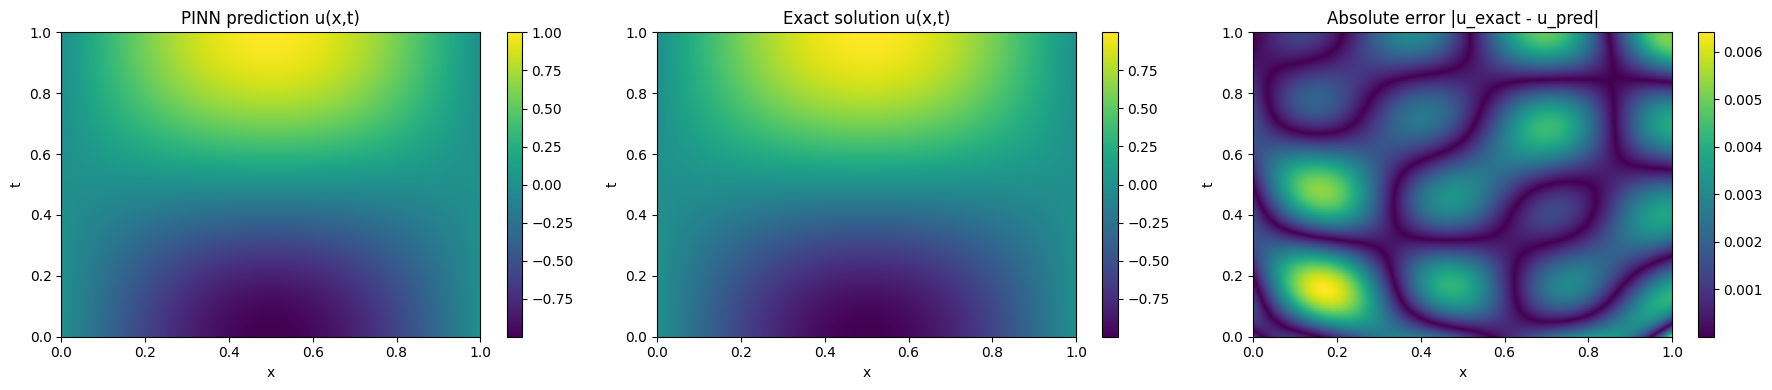

Saved model to pinn_wave_model.pt


In [ ]:
# for the chosen IC (sin(pi x), ut=0, c=1) is cos(pi t)*sin(pi x)

# plot predicted and error
fig, axes = plt.subplots(1,3, figsize=(18,4))
im0 = axes[0].imshow(u_pred, extent=[x_min,x_max,t_min,t_max], aspect='auto')
axes[0].set_title("PINN prediction u(x,t)")
axes[0].set_xlabel("x"); axes[0].set_ylabel("t")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(u_exact, extent=[x_min,x_max,t_min,t_max], aspect='auto')
axes[1].set_title("Exact solution u(x,t)")
axes[1].set_xlabel("x"); axes[1].set_ylabel("t")
fig.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(np.abs(u_exact - u_pred), extent=[x_min,x_max,t_min,t_max], aspect='auto')
axes[2].set_title("Absolute error |u_exact - u_pred|")
axes[2].set_xlabel("x"); axes[2].set_ylabel("t")
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

# save model
torch.save(model.state_dict(), "pinn_wave_model.pt")
print("Saved model to pinn_wave_model.pt")

In [ ]:
count=0
while count <5:
    print(count, "is less than 5")
    count=count+1
else:
    print(count, "is not less than 5")

0 is less than 5
1 is less than 5
2 is less than 5
3 is less than 5
4 is less than 5
5 is not less than 5


In [ ]:
import numpy as np
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt
import random